In [1]:
from klkmeans import kl_kMeans

In [2]:
from helper import calculate_likelihood_em

In [5]:
from sklearn.externals import joblib
import pandas as pd

onlineEM = joblib.load('pkl/onlineEM_15_days_7_alligned.pkl')
test1 = joblib.load('pkl/groupped_data_15_days_00001_04320.pkl')
test2 = joblib.load('pkl/groupped_data_15_days_04321_08640.pkl')
test3 = joblib.load('pkl/groupped_data_15_days_08641_12960.pkl')
test4 = joblib.load('pkl/groupped_data_15_days_12961_17280.pkl')
groupped_data = pd.concat([test1, test2, test3, test4])
groupped_data1 = joblib.load('pkl/groupped_data_15_days_17281_21600.pkl')

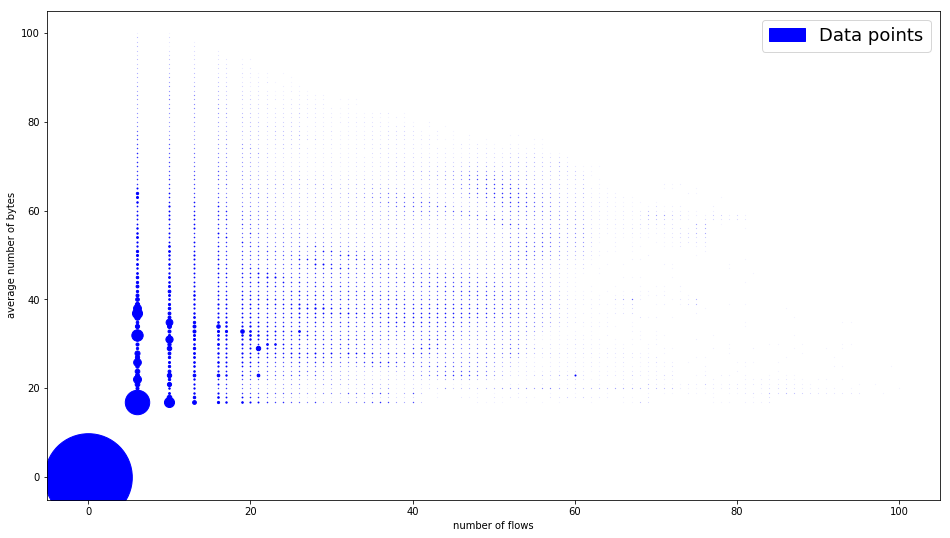

In [6]:
from plots import plot_points
%matplotlib inline

plot_points(groupped_data.values[:,:2])

Should this be done?

for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for l in  tm:
        l[l==0] = 0.00001

Or this?

for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, point in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        if point == 0:
            tm[i] = np.zeros(onlineEM.m)

In [18]:
# Percentage of times each states leads to the same state
total = 0
same = 0

total_except_zero = 0
same_except_zero = 0
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    points_per_cluster = onlineEM.hosts[host]['points_per_cluster']
    total += sum(points_per_cluster)
    total_except_zero += sum(points_per_cluster[1:])
    i = 0
    for p, tvector in zip(points_per_cluster, tm):
        same += tm[i][i] * p
        if i != 0:
            same_except_zero += tm[i][i] * p
        i += 1

    
print('Percentage of times the next state is the same of the previous' , same / total * 100, '%')
print('Percentage of times the next state is the same of the previous not regarding zero traffic', 
      same_except_zero / total_except_zero * 100, '%')

Percentage of times the next state is the same of the previous 70.4634250851 %
Percentage of times the next state is the same of the previous not regarding zero traffic 29.4609448236 %


Initialize hmm 

In [19]:
import numpy as np

m = onlineEM.m

initialize = np.eye(m)

for i in range(m):
    for j in range(m):
        if i != j:
            initialize[i][j] = 0.5
            
    initialize[i] /= (1 + 0.5 * (m - 1))

In [20]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

Running the kmeans algorithm

In [108]:
kmeans = kl_kMeans(onlineEM, n_clusters=18, n_iters=15, n_runs=10)
C, assign = kmeans.run(verbose=1, initialization='k++')

Starting run 1
Starting run 2
Starting run 3
Starting run 4
Starting run 5
Starting run 6
Starting run 7
Starting run 8
Starting run 9
Starting run 10


In [109]:
import matplotlib.pyplot as plt 
from pylab import rcParams

rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 16

### Categorize hosts

In [110]:
from klkmeans import hmm_distance

distances = []
for host in onlineEM.hosts:
    distances.append([host, hmm_distance(onlineEM.hosts[host]['transition_matrix'], kmeans.centers[assign[host]])])

In [111]:
from plots import plot_points_host

#### Here are the mst anomalous hosts

In [112]:
# hosts with the higher distance respective to their kmeans center
sorted(distances, key=lambda x: -x[1])[:10]

[['C1707', 1.9808411215581345],
 ['C1340', 1.8237101211197064],
 ['C473', 1.518958103505321],
 ['C23382', 1.2934107098694947],
 ['C202', 1.2849188586898042],
 ['C4174', 1.2482670894638794],
 ['C2519', 1.2391499092942375],
 ['C314', 1.2371181893068832],
 ['C1823', 1.2010558212601818],
 ['C3871', 1.1931111889007631]]

In [28]:
#find best parameters!!!

def find_percentage(sorted_distances, every=range(10,100,10)):
    total = len(sorted_distances)
    distances = {}
    for k in every:
        distances[k] = sorted_distances[1 - int(total*k/100)][1]
    return distances

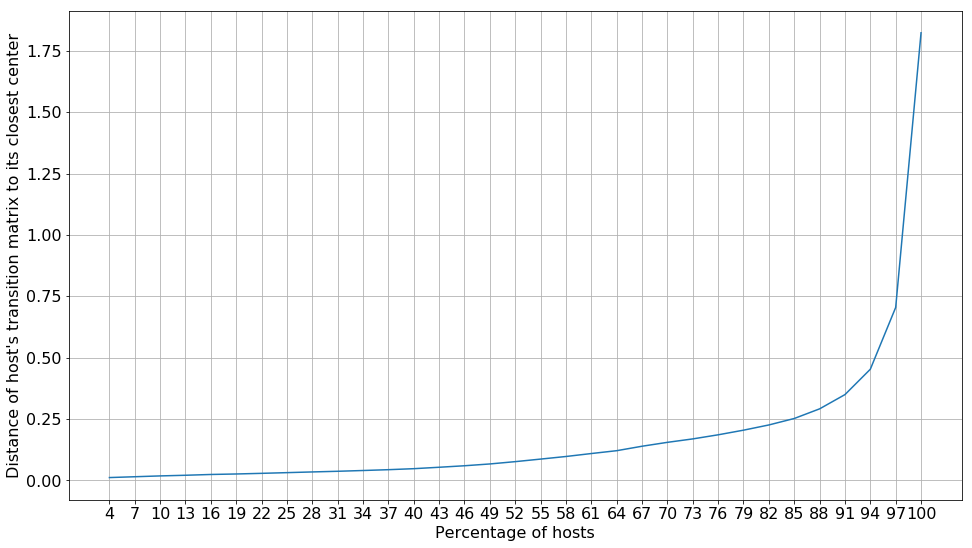

In [145]:
from pylab import rcParams
from matplotlib import pyplot as plt

colors = ['blue', 'red', 'green', 'yellow', 'black']
rcParams['font.size'] = 16
rcParams['figure.figsize'] = 16, 9

sorted_distances = sorted(distances, key=lambda x: -x[1])

ranges = range(4,101,3)

percentages = list(find_percentage(sorted_distances, every=ranges).values())
  
plt.plot(list(ranges), percentages)
plt.xlabel('Percentage of hosts')
plt.ylabel('Distance of host\'s transition matrix to its closest center')
plt.xticks(ranges)
plt.grid() 
plt.show()

In [114]:
# Find the average distances of hosts from their center in each cluster
import numpy as np
from klkmeans import hmm_distance


average_distances = {}
for k,v in kmeans.assignments.items():
    # manually inserted anomalous host
    if k.startswith("A"):
        continue
    if v in average_distances:
        average_distances[v].append(hmm_distance(onlineEM.hosts[k]['transition_matrix'], kmeans.centers[v]))
    else:
        average_distances[v] = []
        average_distances[v].append(hmm_distance(onlineEM.hosts[k]['transition_matrix'], kmeans.centers[v]))
        
for k,v in sorted(average_distances.items()):
    print('Average distances from enter  {:2d} for the hosts with this as their closest center is {:.3f}'.format(k, 
                                                                                                                 sum(v)/len(v)))

Average distances from enter   0 for the hosts with this as their closest center is 0.044
Average distances from enter   1 for the hosts with this as their closest center is 0.027
Average distances from enter   2 for the hosts with this as their closest center is 0.158
Average distances from enter   3 for the hosts with this as their closest center is 0.046
Average distances from enter   4 for the hosts with this as their closest center is 0.466
Average distances from enter   5 for the hosts with this as their closest center is 0.211
Average distances from enter   6 for the hosts with this as their closest center is 0.262
Average distances from enter   7 for the hosts with this as their closest center is 0.643
Average distances from enter   8 for the hosts with this as their closest center is 0.197
Average distances from enter   9 for the hosts with this as their closest center is 0.797
Average distances from enter  10 for the hosts with this as their closest center is 0.798
Average di

Host C1707 has the most anomalous behavior


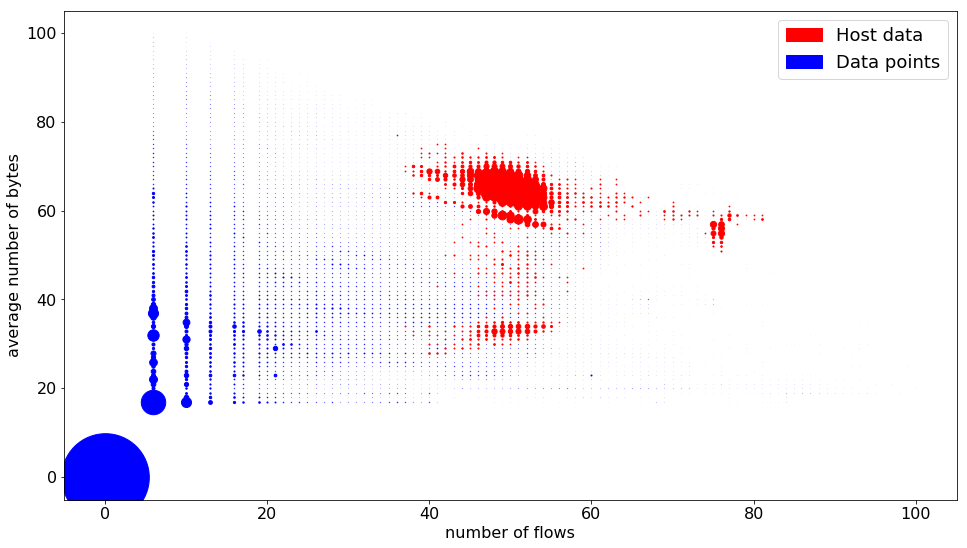

In [115]:
host = sorted_distances[0][0]
print('Host', host, 'has the most anomalous behavior')
plot_points_host(groupped_data.values[:, :2], hostData=groupped_data[groupped_data['source computer'] == host].values[:, :2])

In [116]:
from pylab import rcParams
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches

import seaborn as sns


colors = ['blue', 'red', 'green', 'yellow']
styles = ['-','--',':','-.']
rcParams['font.size'] = 16
# HOST and clusters
%matplotlib inline

def plot_transition_matrix(em, kmeans, host):
    rcParams['figure.figsize'] = 16, 9

    plt.subplot(1,2,1)
    ax = sns.heatmap(em.hosts[host]['transition_matrix'])
    plt.title('Host transition matrix')
    
    plt.subplot(1,2,2)
    ax = sns.heatmap(kmeans.centers[kmeans.assignments[host]])
    plt.title('Kmeans center transition matrix for center ' + str(kmeans.assignments[host]))
    plt.show()

In [117]:
onlineEM.lambdas

array([[0.0, 0.0],
       [55.35796116568266, 55.5106133016459],
       [7.490530257660513, 33.61984253955143],
       [9.192336417675378, 56.81490528692768],
       [19.384708222786813, 31.1284045736644],
       [36.29728398378874, 37.89205204878816],
       [7.0770611843650215, 18.8042149465344]], dtype=object)

In [118]:
onlineEM.hosts[host]['points_per_cluster']

array([     0.,  16511.,      0.,      0.,      0.,    768.,      0.])

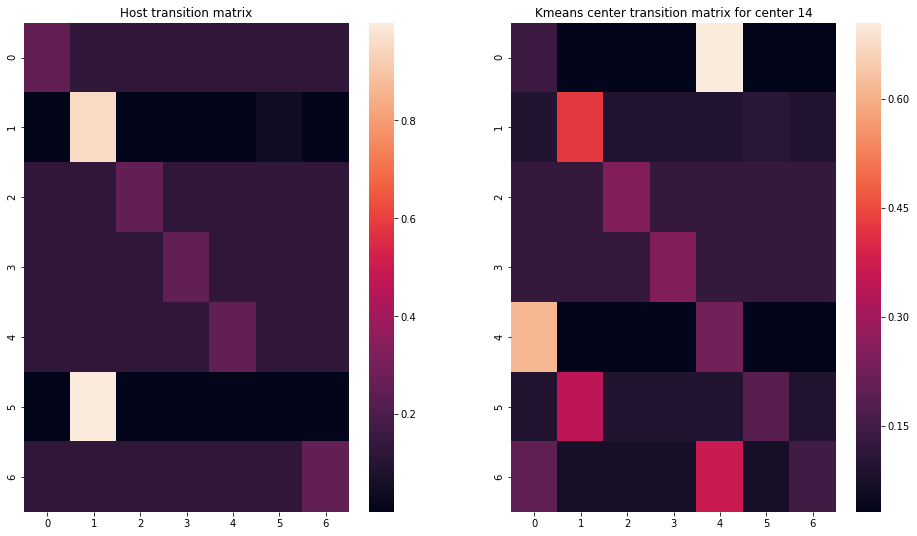

In [119]:
plot_transition_matrix(onlineEM, kmeans, host)

In [120]:
import collections
    
centers = {}
for host in onlineEM.hosts:
    if kmeans.assignments[host] in centers:
        centers[kmeans.assignments[host]] += 1 
    else:
        centers[kmeans.assignments[host]] = 1


participations = collections.OrderedDict(sorted(centers.items()))
print(participations)

OrderedDict([(0, 720), (1, 95), (2, 378), (3, 274), (4, 18), (5, 41), (6, 101), (7, 9), (8, 35), (9, 24), (10, 33), (11, 127), (12, 68), (13, 141), (14, 4), (15, 122), (16, 65), (17, 13)])


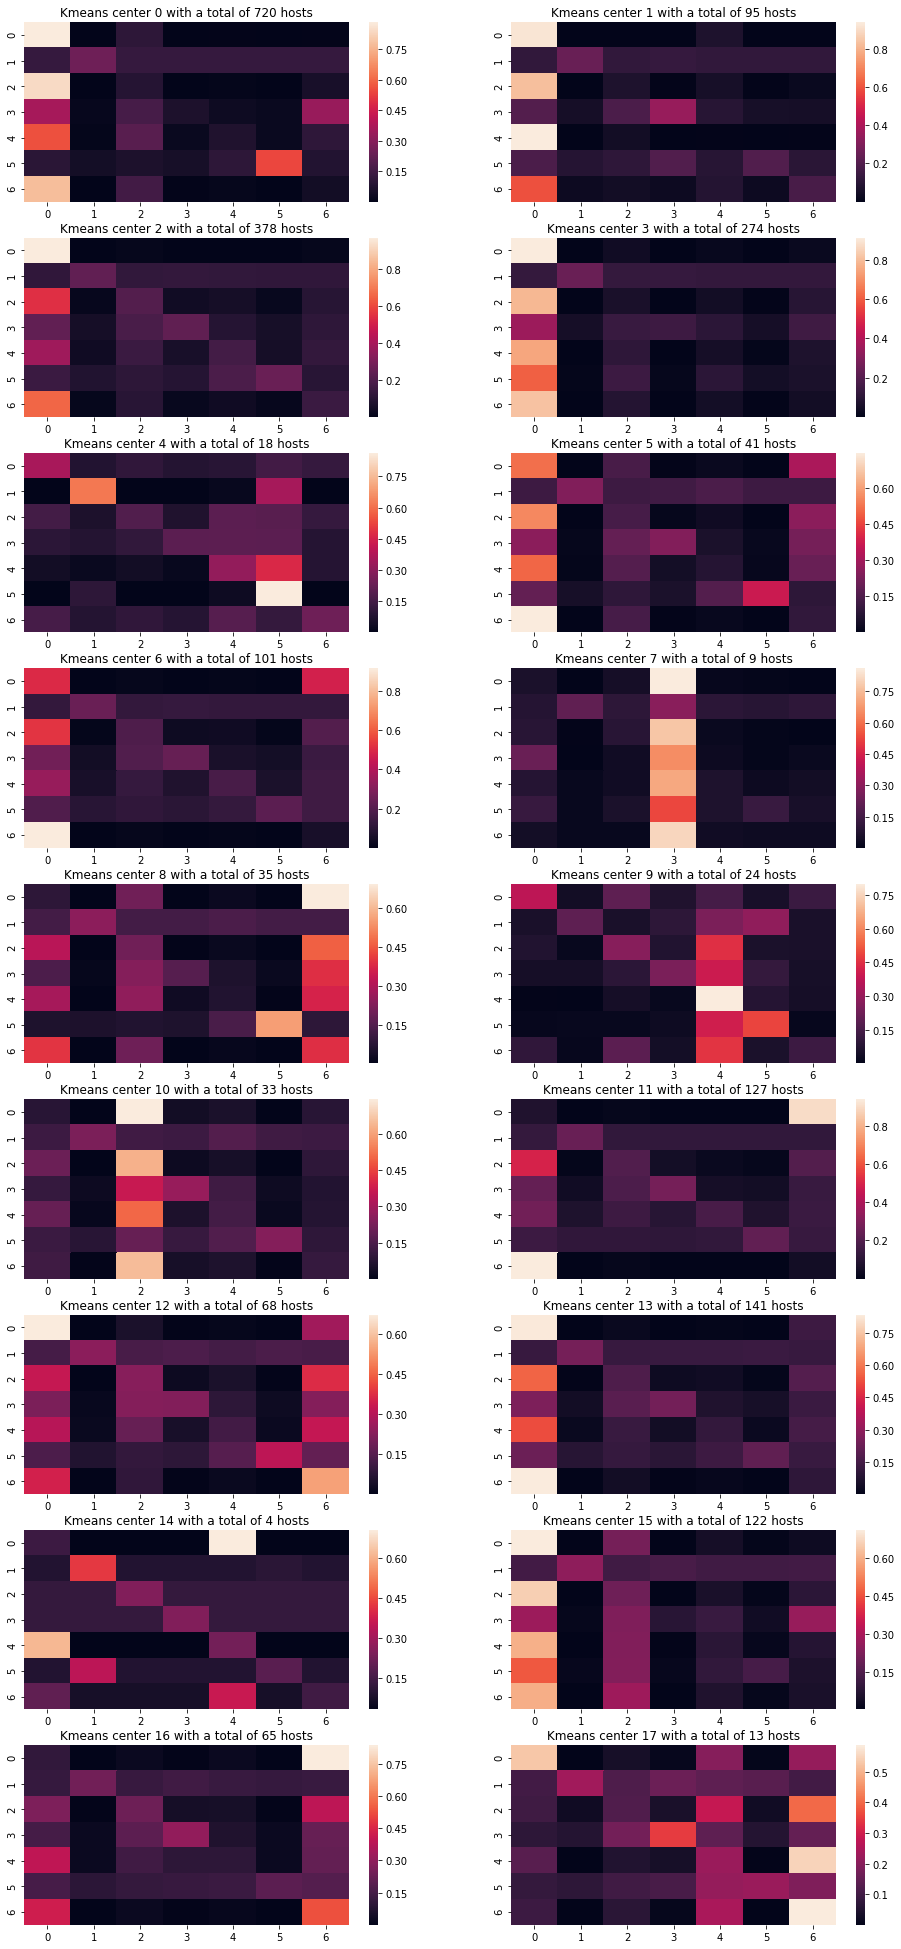

In [121]:
rcParams['figure.figsize'] = 16, 35
    
for i in range(len(kmeans.centers)):
    plt.subplot(len(kmeans.centers) / 2,2,i+1)
    ax = sns.heatmap(kmeans.centers[i])
    if i in participations:
        num = str(participations[i])
    else:
        num = str(0)
    plt.title('Kmeans center ' + str(i) + ' with a total of ' + num + ' hosts')

plt.show()

#### Create random traffic for a new host

In [134]:
# RANDOM COMBINATION OF FLOWS AND NUMBER OF BYTES
import random as ran
import random

random_flows = list(set(groupped_data['number of flows'].values))
random_average_bytes = list(set(groupped_data['mean(byte count)'].values))

anomalous_host = 'A70'
epochs = 1500

data = []
for i in range(epochs):
    #flows = ran.randint(1,50)
    #average_bytes = ran.randint(1,50)
    flows = random.choice(random_flows)
    average_bytes = random.choice(random_average_bytes)
    data.append([flows, average_bytes, anomalous_host])

    
for data_point in data:
    onlineEM.update_host(data_point)

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


In [141]:
#RANDOM VALUE ENCOUNTERED IN THE SET OF GROUPED_DATA
import random as ran
import random

size = 10000

test_df = groupped_data.head(size)
unique_values = np.vstack({tuple(row) for row in test_df.values[:,:2]})

anomalous_host = 'A71'
epochs = 1500

data = []
for i in range(epochs):
    values = random.choice(unique_values)
    data.append([values[0], values[1], anomalous_host])

    
for data_point in data:
    onlineEM.update_host(data_point)

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


In [146]:
#RANDOM VALUE ENCOUNTERED IN GROUPED_DATA
import random as ran
import random

size = 10000

test_df = groupped_data.head(size)

anomalous_host = 'A72'
epochs = 1500

data = []
for i in range(epochs):
    values = random.choice(test_df.values[:,:2])
    data.append([values[0], values[1], anomalous_host])

    
for data_point in data:
    onlineEM.update_host(data_point)

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


In [147]:
tm = onlineEM.hosts[anomalous_host]['transition_matrix']
for i, points in enumerate(onlineEM.hosts[anomalous_host]['points_per_cluster']):
    tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

In [148]:
distances_for_anomalous_host = []
for i in range(len(kmeans.centers)):
    distances_for_anomalous_host.append([i, hmm_distance(onlineEM.hosts[anomalous_host]['transition_matrix'], 
                                         kmeans.centers[i]) ])

In [149]:
distances_for_anomalous_host.sort(key=lambda x: x[1])
distances_for_anomalous_host

[[3, 0.090955793205903801],
 [13, 0.16053752155137183],
 [0, 0.21818726722130735],
 [15, 0.25251479872804911],
 [2, 0.31458899551573333],
 [5, 0.4933874470686837],
 [1, 0.5666598979779397],
 [12, 0.78997886399994177],
 [6, 0.85766698184351342],
 [17, 1.9102628909389292],
 [8, 2.498840636244732],
 [14, 2.6257677365463188],
 [16, 2.6290906084129562],
 [11, 2.7351003577146766],
 [10, 2.9318638875751581],
 [9, 2.9942137409121523],
 [4, 3.4292664058387707],
 [7, 4.5211113758735246]]

In [150]:
onlineEM.hosts[anomalous_host]['points_per_cluster']

array([  1.23900000e+03,   1.00000000e+00,   1.07000000e+02,
         2.00000000e+00,   3.80000000e+01,   7.00000000e+00,
         1.05000000e+02])

In [153]:
kmeans.assignments[anomalous_host] = 7

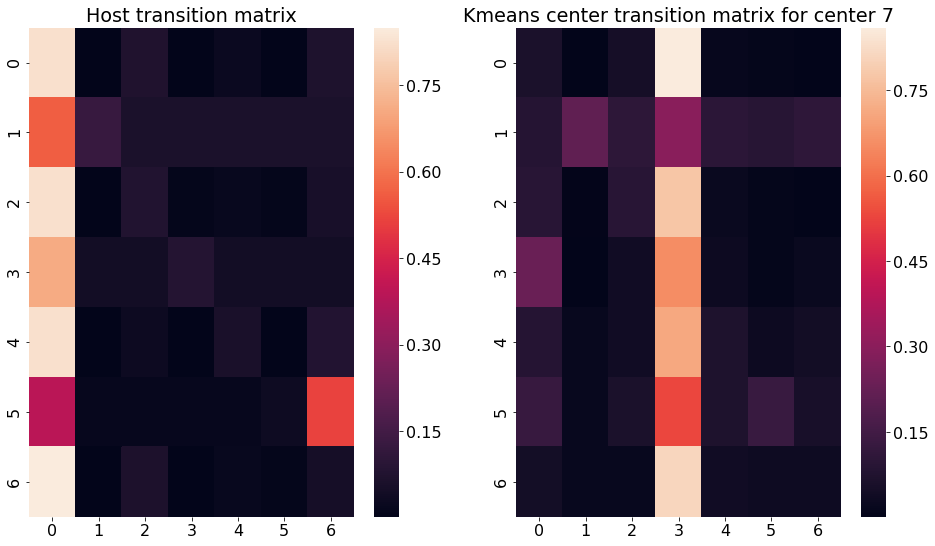

In [154]:
plot_transition_matrix(onlineEM, kmeans, anomalous_host)

## Number of clusters to choose

In [95]:
from klkmeans import hmm_distance
import copy

results = {}
kmeans_all = {}
clusters = list(range(10,31))
for n_clusters in clusters:
    print('Now running fot number of clusters', n_clusters)
    kmeans = kl_kMeans(onlineEM, n_clusters=n_clusters, n_iters=15, n_runs=10)
    C, assign = kmeans.run(verbose=0, initialization='k++')
     
    distances = []
    for host in onlineEM.hosts:
        distances.append([host, hmm_distance(onlineEM.hosts[host]['transition_matrix'], kmeans.centers[assign[host]])])
        
    sorted_distances = sorted(distances, key=lambda x: -x[1])
    results[n_clusters] = sorted_distances.copy()
    kmeans_all[n_clusters] = copy.deepcopy(kmeans)

Now running fot number of clusters 10
Now running fot number of clusters 11
Now running fot number of clusters 12
Now running fot number of clusters 13
Now running fot number of clusters 14
Now running fot number of clusters 15
Now running fot number of clusters 16


D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\klkmeans.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  total_distance += P[i] * log(P[i]/Q[i])


Now running fot number of clusters 17
Now running fot number of clusters 18
Now running fot number of clusters 19
Now running fot number of clusters 20
Now running fot number of clusters 21
Now running fot number of clusters 22
Now running fot number of clusters 23
Now running fot number of clusters 24
Now running fot number of clusters 25
Now running fot number of clusters 26
Now running fot number of clusters 27
Now running fot number of clusters 28
Now running fot number of clusters 29
Now running fot number of clusters 30


In [96]:
ranges = range(10,100,5)

percentages = []
for n_clusters in clusters:
    percentages.append(list(find_percentage(results[n_clusters], every=ranges).values()))

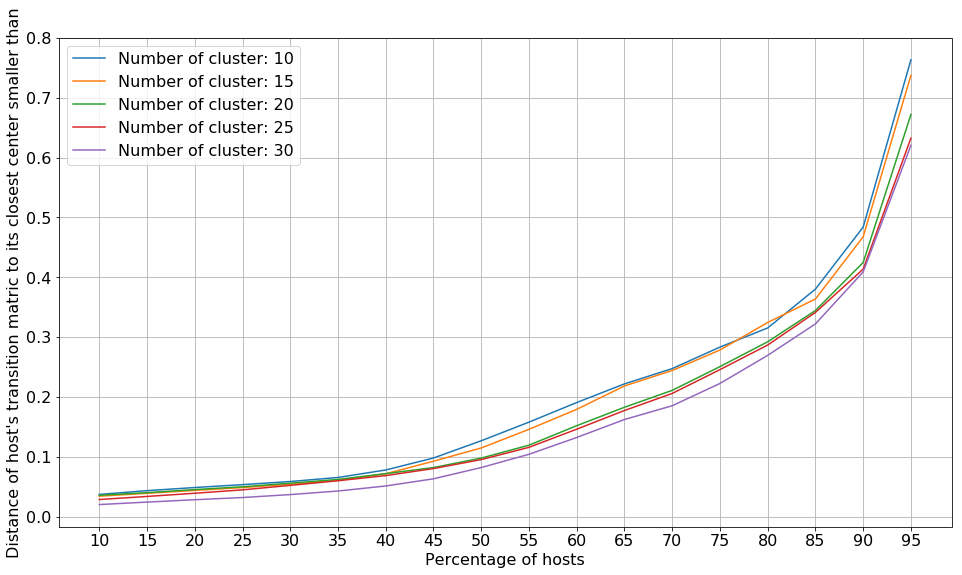

In [99]:
from pylab import rcParams
from matplotlib import pyplot as plt

colors = ['blue', 'red', 'green', 'yellow', 'black']
rcParams['font.size'] = 16
rcParams['figure.figsize'] = 16, 9

show_clusters = [10, 15, 20, 25, 30]
for percentage, color, n_clusters in zip(percentages, colors, show_clusters):
    plt.plot(ranges, percentage, label='Number of cluster: ' + str(n_clusters))

plt.xlabel('Percentage of hosts')
plt.ylabel('Distance of host\'s transition matric to its closest center smaller than')
plt.xticks(ranges)
plt.grid()
plt.legend()    
plt.show()

### Inertia plot

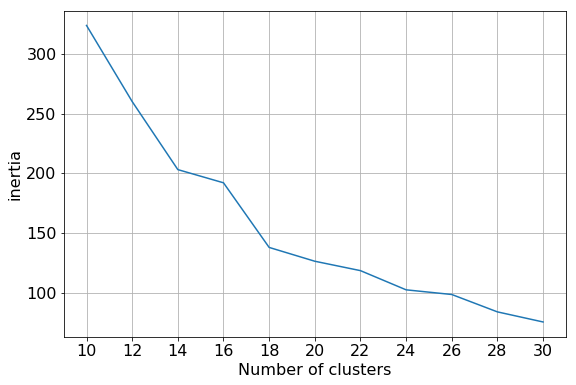

In [107]:
rcParams['figure.figsize'] = 9, 6

inertia = []
show_clusters = list(range(10, 31, 2))

for n_clusters in show_clusters:
    distances = results[n_clusters]
    inertia.append(sum([x*x for [_, x] in distances]))

plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.xticks(show_clusters)
plt.grid()
plt.plot(show_clusters, inertia)